<a href="https://colab.research.google.com/github/ykitaguchi77/GO_AI_project/blob/main/Train_Super_extend_dataset_iFish_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Train GO super-extend dataset iFish YOLOv5**

Train YOLOv5 using iFish augmentation

```
iFish: https://github.com/Gil-Mor/iFish.git

yolov5_iFish: https://github.com/ykitaguchi77/yolov5-iFish.git
※ FishAugment(distortion_range=(0, 0.3), p=0.5)

```

Output as CoreML

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import pandas as pd
import csv
from random import randint
from time import sleep
import numpy as np
import sys
import torch


import glob
import random
from PIL import Image
%matplotlib inline

# #サポートパッチのインポート
# from google.colab.patches import cv2_imshow
# import cv2

plt.ion()   # interactive mode
!nvidia-smi
print(torch.cuda.is_available())


Sat Oct  7 07:24:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Google colabをマウント

In [2]:
'''
・dlibを用いて目を切り抜く
・横幅を2倍、縦幅を上に1倍追加/下に0.5倍追加した両眼の画像が含まれるように切り取る（目の全幅、眉毛が含まれるように）
'''

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#残り時間確認
!cat /proc/uptime | awk '{printf("残り時間 : %.2f", 12-$1/60/60)}'


残り時間 : 11.95

In [ ]:
print(f"train_images: {len(os.listdir('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/train/images'))}")
print(f"val_images: {len(os.listdir('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/valid/images'))}")
print(f"train_labels: {len(os.listdir('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/train/labels'))}")
print(f"val_labels: {len(os.listdir('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/valid/labels'))}")

def check_basename(image_dir, label_dir):
    # 画像ファイルのベースネーム一覧を取得
    image_files = [os.path.splitext(file)[0] for file in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, file))]
    image_files = set(image_files)  # 重複を削除

    # ラベルファイルのベースネーム一覧を取得
    label_files = [os.path.splitext(file)[0] for file in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, file))]
    label_files = set(label_files)  # 重複を削除

    # ファイルのベースネームが完全に一致するか確認
    match = image_files == label_files

    if match:
        print("すべてのファイルのベースネームが一致しています。")
    else:
        print("ファイルのベースネームが一致していません。")

check_basename('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/train/images', '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/train/labels')
check_basename('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/valid/images', '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/valid/labels')

train_images: 3498
val_images: 795
train_labels: 3498
val_labels: 795
すべてのファイルのベースネームが一致しています。
すべてのファイルのベースネームが一致しています。


In [ ]:
import os

directory = '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/train/labels'

# ディレクトリ内のファイルを取得
files = os.listdir(directory)

# テキストファイルを読み込んで表示
for file in files:
    if file.endswith('.txt'):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            content = f.read().strip()
            if content:
                print(f"ファイル名: {file}\n内容: {content}\n")
            else:
                print(f"ファイル名: {file}\nエラー: ファイルの内容が空欄です。\n")
                sys.exit(1)  # プログラムを中止


#**Albumentationによるデータ拡張**

(YOLOv5-iFish https://github.com/ykitaguchi77/yolov5-iFish.git に組み込み済み)

In [ ]:
import random
import numpy as np
from albumentations import DualTransform
from math import sqrt
import albumentations as A


class FishEyeEffect(DualTransform):
    def __init__(self, always_apply=False, p=0.5):
        super(FishEyeEffect, self).__init__(always_apply, p)
        self.image_shape = None  # Initialize the instance variable to store image shape


    def get_fish_xn_yn(self, source_x, source_y, radius, distortion):
        if 1 - distortion*(radius**2) == 0:
            return source_x, source_y
        return source_x / (1 - (distortion*(radius**2))), source_y / (1 - (distortion*(radius**2)))

    def get_original_xn_yn(self, dest_x, dest_y, radius, distortion):
        return dest_x * (1 - distortion * (radius**2)), dest_y * (1 - distortion * (radius**2))


    def apply(self, img, distortion=0, **params):
        self.image_shape = img.shape  # set image shape here
        # your fish-eye effect implementation here
        dstimg = np.zeros_like(img)
        w, h = float(img.shape[0]), float(img.shape[1])
        for x in range(len(dstimg)):
            for y in range(len(dstimg[x])):
                xnd, ynd = float((2*x - w)/w), float((2*y - h)/h)
                rd = sqrt(xnd**2 + ynd**2)
                xdu, ydu = self.get_fish_xn_yn(xnd, ynd, rd, distortion)
                xu, yu = int(((xdu + 1)*w)/2), int(((ydu + 1)*h)/2)
                if 0 <= xu < img.shape[0] and 0 <= yu < img.shape[1]:
                    dstimg[x][y] = img[xu][yu]
        return dstimg

    def apply_to_bbox(self, bbox, distortion=0, **params):
        img_h, img_w = self.image_shape[:2]  # Use the stored image shape

        # YOLO形式から4つの角の座標を取得
        x_min, y_min, x_max, y_max = bbox

        # 4つの角の座標を正規化
        corners = [(x_min, y_min),
                  (x_max, y_min),
                  (x_min, y_max),
                  (x_max, y_max)]

        # 正規化された座標を魚眼変換用に変換
        corners = [(2*x - 1, 2*y - 1) for x, y in corners]

        print("Transformed corners:", corners)

        # 各角をFishEyeで逆変換
        distorted_corners = [self.get_original_xn_yn(x, y, sqrt(x**2 + y**2), distortion) for x, y in corners]

        print("Distorted corners:", distorted_corners)

        # 逆変換された点を含む最小の長方形を求める
        x_min_new = min(x for x, y in distorted_corners)
        x_max_new = max(x for x, y in distorted_corners)
        y_min_new = min(y for x, y in distorted_corners)
        y_max_new = max(y for x, y in distorted_corners)

        # 魚眼逆変換後の座標を画像座標系に戻す
        x_min_new = (x_min_new + 1) / 2
        x_max_new = (x_max_new + 1) / 2
        y_min_new = (y_min_new + 1)  / 2
        y_max_new = (y_max_new + 1)  / 2

        print(x_min_new, y_min_new, x_max_new, y_max_new)

        return x_min_new, y_min_new, x_max_new, y_max_new


    def get_params(self):
        # Random distortion coefficient between 0 and 0.3
        return {'distortion': random.uniform(0, 0.3)}


# 変換する関数を定義
transform = A.Compose([
    #A.RandomCrop(width=400, height=400),
    FishEyeEffect(p=1),
    #A.HorizontalFlip(p=1),
    #A.VerticalFlip(p=1),
    A.RandomBrightnessContrast(p=1),
], bbox_params=A.BboxParams(format='yolo',min_area=1024,
min_visibility=0.1, label_fields=['class_labels']))



# 画像読み込み
image = cv2.imread("/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/train/images/1043.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# yoloのアノテーションファイルを読み込み
f = open('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/train/labels/1043.txt', 'r')
anno_lists = f.readlines()
f.close()

# 空の配列を用意
bboxes = []
class_labels = []

# アノテーションファイルをパイプラインに与える形に変換
for anno_list in anno_lists:
    # スペースで区切る
    anno_list = anno_list.split()

    # 0番目の要素からクラスラベルを取り出し
    class_labels.append(anno_list[0])

    # BBoxの値をfloatに変換
    anno_list = [float(i) for i in anno_list[1:]]

    # BBoxの配列に追加
    bboxes.append(anno_list)


# 変換を実行し、変換後のimage, bboxes, class_labelsを取得
transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['class_labels']



# 関数：YOLO形式のバウンディングボックスをmatplotlibのrectangleに変換
def yolo_to_rect(bbox, img_shape):
    cx, cy, w, h = bbox
    img_h, img_w = img_shape[:2]
    tlx = int((cx - w/2) * img_w)
    tly = int((cy - h/2) * img_h)
    rect_w = int(w * img_w)
    rect_h = int(h * img_h)
    return tlx, tly, rect_w, rect_h

# 元の画像とバウンディングボックスを表示
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
for bbox in bboxes:
    tlx, tly, rect_w, rect_h = yolo_to_rect(bbox, image.shape)
    rect = plt.Rectangle((tlx, tly), rect_w, rect_h, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
plt.title('Before Augmentation')

# 変換後の画像とバウンディングボックスを表示
plt.subplot(1, 2, 2)
plt.imshow(transformed_image)
plt.axis('off')
for bbox in transformed_bboxes:
    tlx, tly, rect_w, rect_h = yolo_to_rect(bbox, transformed_image.shape)
    rect = plt.Rectangle((tlx, tly), rect_w, rect_h, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
plt.title('After Augmentation')

plt.show()


# # To save the transformed annotations:
# with open('result.txt', 'w') as f:
#     for i, transformed_bbox in enumerate(transformed_bboxes):
#         f.write("{} {} {} {} {}\n".format(
#             transformed_class_labels[i],
#             transformed_bbox[0], transformed_bbox[1],
#             transformed_bbox[2], transformed_bbox[3]
#         ))



#**Setup YOLOv5**

In [ ]:
%cd /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training
!git clone https://github.com/ykitaguchi77/yolov5-iFish.git #iFish augmentationを実装したバージョン
%cd yolov5-iFish
%pip install -qr requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (8 CPUs, 51.0 GB RAM, 26.3/166.8 GB disk)


#**Train YOLOv5**

In [ ]:
# Train
!python train.py --img 640 --batch 16 --epochs 300 --data /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/dataset.yaml --weights yolov5n.pt


In [ ]:
# 途中から
!python train.py --img 640 --batch 16 --epochs 300 --data /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/dataset.yaml --resume /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish/runs/train/exp2/weights/last.pt


In [ ]:
# best.pyをrenameしてgdriveに移動しておく
orig_pt = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish/runs/train/exp2/weights/best.pt"
dst_pt = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt"
shutil.copy(orig_pt, dst_pt)

'/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt'

#**Show examples**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import glob

val_images_dir = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/valid/images"
val_labels_dir = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/valid/labels"

for sample_num in range(21):
    sample_image_path = glob.glob(f"{val_images_dir}/*")[sample_num]
    sample_label_path = glob.glob(f"{val_labels_dir}/*")[sample_num]

    # 画像の読み込み
    image = cv2.imread(sample_image_path)
    height, width = image.shape[:2]
    image = cv2.resize(image, (640, int(height * 640 / width)))

    # バウンディングボックスの情報
    with open(sample_label_path, "r", encoding="utf-8") as file:
        content = file.read()
    content_list = content.split()

    # バウンディングボックスの座標を計算
    x = float(content_list[1]) * image.shape[1]
    y = float(content_list[2]) * image.shape[0]
    box_width = float(content_list[3]) * image.shape[1]
    box_height = float(content_list[4]) * image.shape[0]

    # バウンディングボックスの座標を計算
    left = int(x - (box_width / 2))
    top = int(y - (box_height / 2))
    right = int(x + (box_width / 2))
    bottom = int(y + (box_height / 2))

    # バウンディングボックスを画像に重ねる
    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)

    # 画像の表示
    cv2_imshow(image)


#**Interference Olympia dataset**

In [3]:
%cd /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish

import torch
import utils
%pip install -qr requirements.txt
display = utils.notebook_init()

YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (8 CPUs, 51.0 GB RAM, 26.5/166.8 GB disk)


In [4]:
# YOLOv5
#weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish/runs/train/exp2/weights/best.pt"
#weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt"
weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolov5n_130epch.pt"

# 横幅を640pxにリサイズしたデータセット
dataset_olympia_grav = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/grav"
dataset_olympia_cont = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/cont"
dataset_handai_grav = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/handai/grav"
dataset_handai_cont = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/handai/cont"

In [5]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox #padding

from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow


def interference(img, weight):
    device = 'cpu'
    device = select_device(device)
    model = DetectMultiBackend(weight, device=device, dnn=False)
    #stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
    #imgsz = check_img_size([640], s=stride)  # check image size

    #class_names = {0:"cont", 1:"grav"}

    # transform = transforms.Compose([
    #             transforms.Resize(size=(480,640)),
    #             transforms.ToTensor(),
    #             # transforms.Normalize(
    #             #     mean=[0.5, 0.5, 0.5],
    #             #     std=[0.5, 0.5, 0.5]
    #             #    )
    #             ])

    img_cv2 = cv2.imread(img) #CV2で開く
    img_cv2 = letterbox(img_cv2, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

    #cv2_imshow(img_cv2)

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    #img_tensor = transform(img_np)
    img_tensor /= 255
    #print(img_tensor.shape)

    #print(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応


    pred = model(img_tensor, visualize=False, augment=False)

    pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, classes=None,  max_det=1000)

    print(f"pred: {pred}")

    return pred

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import glob


image_path = glob.glob(f"{dataset_olympia_grav}/*")
start_index = 1
end_index = 5

class_names = {0: "cont", 1: "grav"}

for i in range(start_index, end_index + 1):
    img = image_path[i]

    pred = interference(img, weight)

    # output result
    x1, y1, x2, y2, prob, class_num = torch.round(pred[0][0])

    # probability
    prob = pred[0][0][4].item()

    # class
    class_name = class_names[pred[0][0][5].item()]

    print("診断は %s、確率は%.1f％です。" % (class_name, prob * 100))

    img_cv2 = cv2.imread(img)
    img_cv2 = cv2.resize(img_cv2, (640, int(img_cv2.shape[0] * 640 / img_cv2.shape[1])))  # 横幅を640pxにリサイズ

    # calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
    img_height, img_width, _ = img_cv2.shape[:3]
    print(f"img_height: {img_height}, img_width: {img_width}")
    padding_x = (img_height - min(img_width, img_height)) / 2
    padding_y = (img_width - min(img_width, img_height)) / 2
    x1 = x1 - padding_x
    y1 = y1 - padding_y
    x2 = x2 - padding_x
    y2 = y2 - padding_y
    print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

    # draw bounding box
    cv2.rectangle(img_cv2, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # show image
    cv2_imshow(img_cv2)


In [7]:
#Testsetの正解率を確認
import cv2
from google.colab.patches import cv2_imshow
import glob

class_names = {0: "cont", 1: "grav"}



def interference_testset(image_path, answer):
    pred_list = []
    correct_list = [] #正解なら1、不正解なら0

    for img in image_path:
        pred = interference(img, weight)

        # output result
        x1, y1, x2, y2, prob, class_num = torch.round(pred[0][0])

        # probability
        prob = pred[0][0][4].item()

        # class
        class_name = class_names[pred[0][0][5].item()]

        if class_name == answer:
            correct_list.append(1)
        else:
            correct_list.append(0)

        print("診断は %s、確率は%.1f％です。" % (class_name, prob * 100))

    total_count = len(correct_list)
    one_count = correct_list.count(1)
    percentage = (one_count / total_count) * 100
    print("")
    print(f"image_path: {image_path}")
    print(f"The percentage of corrects in the list is: {percentage:.2f}%")
    print("")
    print("")
    print("")
    print("")
    print("")
    print("")
    print("")
    print("")

interference_testset(glob.glob(f"{dataset_olympia_grav}/*"), "grav")
interference_testset(glob.glob(f"{dataset_olympia_cont}/*"), "cont")
interference_testset(glob.glob(f"{dataset_handai_grav}/*"), "grav")
interference_testset(glob.glob(f"{dataset_handai_cont}/*"), "cont")


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -1.70355, 138.70728, 644.28302, 441.73566,   0.64665,   1.00000]])]
診断は grav、確率は64.7％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -2.31137, 165.40912, 638.23071, 444.68445,   0.74504,   1.00000]])]
診断は grav、確率は74.5％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 20.85608, 211.34940, 643.74554, 497.79745,   0.88691,   1.00000]])]
診断は grav、確率は88.7％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -2.34921, 180.51508, 638.55359, 487.60406,   0.90337,   1.00000]])]
診断は grav、確率は90.3％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -0.78745, 146.78674, 634.77100, 454.88123,   0.76212,   0.00000]])]
診断は cont、確率は76.2％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[1.46110e+01, 2.32910e+02, 6.41237e+02, 5.10322e+02, 4.85753e-01, 1.00000e+00],
        [1.33612e+01, 2.28658e+02, 6.46153e+02, 5.11973e+02, 4.48850e-01, 0.00000e+00]])]
診断は grav、確率は48.6％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -2.14285, 197.09471, 637.36584, 480.41608,   0.90967,   1.00000]])]
診断は grav、確率は91.0％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -4.89996, 160.15018, 636.22784, 452.06918,   0.83004,   1.00000]])]
診断は grav、確率は83.0％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[-6.29578e-01,  1.78975e+02,  6.38321e+02,  4.66728e+02,  7.23508e-01,  0.00000e+00]])]
診断は cont、確率は72.4％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU



pred: [tensor([[ -1.49365, 159.88037, 641.74420, 449.90808,   0.92091,   1.00000]])]
診断は grav、確率は92.1％です。


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  2.08350, 190.31836, 632.75165, 478.01599,   0.90521,   0.00000]])]
診断は cont、確率は90.5％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 14.93225, 181.73441, 640.23145, 456.60287,   0.68715,   0.00000]])]
診断は cont、確率は68.7％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -1.23230, 153.00139, 640.03845, 453.07446,   0.89444,   1.00000]])]
診断は grav、確率は89.4％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 


pred: [tensor([[ -1.78079, 173.36900, 635.71216, 470.51251,   0.74851,   1.00000]])]
診断は grav、確率は74.9％です。


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -3.48456, 169.07253, 635.67694, 447.23669,   0.75045,   0.00000]])]
診断は cont、確率は75.0％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -1.36035, 138.39273, 639.89569, 428.60422,   0.75585,   1.00000]])]
診断は grav、確率は75.6％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[-6.38245e-01,  1.55412e+02,  6.41627e+02,  4.81086e+02,  7.64247e-01,  0.00000e+00]])]
診断は cont、確率は76.4％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.91608, 158.07794, 640.83478, 460.91022,   0.91377,   1.00000]])]
診断は grav、確率は91.4％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -0.96442, 200.28270, 633.43225, 481.02722,   0.87217,   0.00000]])]
診断は cont、確率は87.2％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -2.44730, 139.78058, 639.14954, 440.25482,   0.69870,   0.00000]])]
診断は cont、確率は69.9％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -1.79440, 171.40714, 639.85376, 486.36661,   0.85904,   1.00000]])]
診断は grav、確率は85.9％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  5.44958, 177.36687, 640.51434, 454.37531,   0.73832,   1.00000]])]
診断は grav、確率は73.8％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -3.77380, 206.85028, 641.18579, 489.36133,   0.88567,   1.00000]])]
診断は grav、確率は88.6％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU



pred: [tensor([[-1.81912e+00,  1.97588e+02,  6.31453e+02,  4.78251e+02,  6.76420e-01,  1.00000e+00],
        [-2.16309e-01,  2.03617e+02,  6.27348e+02,  4.73350e+02,  4.39229e-01,  0.00000e+00]])]
診断は grav、確率は67.6％です。


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  2.80768, 208.61014, 627.80945, 493.77103,   0.72652,   1.00000]])]
診断は grav、確率は72.7％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -2.11282, 192.29759, 639.08301, 474.99707,   0.83348,   0.00000]])]
診断は cont、確率は83.3％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -2.93878, 159.68927, 639.76654, 440.66815,   0.89922,   1.00000]])]
診断は grav、確率は89.9％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -2.65549, 181.70842, 637.35657, 486.51276,   0.88340,   1.00000]])]
診断は grav、確率は88.3％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[2.80701e-01, 1.72999e+02, 6.35048e+02, 4.62299e+02, 8.44456e-01, 1.00000e+00]])]
診断は grav、確率は84.4％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -3.12350, 163.96353, 640.70215, 472.84744,   0.76111,   1.00000]])]
診断は grav、確率は76.1％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  4.59268, 169.18930, 642.57642, 484.78891,   0.67079,   0.00000]])]
診断は cont、確率は67.1％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[-1.23779e-01,  1.52501e+02,  6.42560e+02,  4.47502e+02,  9.09292e-01,  1.00000e+00]])]
診断は grav、確率は90.9％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -0.95377, 154.83125, 640.98889, 476.89691,   0.75279,   1.00000]])]
診断は grav、確率は75.3％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 12.66037, 216.55437, 639.00269, 480.97699,   0.86114,   0.00000]])]
診断は cont、確率は86.1％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[-2.52930e-01,  1.48226e+02,  6.41238e+02,  4.68632e+02,  5.87852e-01,  0.00000e+00],
        [-1.58411e+00,  1.47147e+02,  6.35111e+02,  4.67542e+02,  5.76450e-01,  1.00000e+00]])]
診断は cont、確率は58.8％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -0.70502, 164.42682, 638.58606, 474.18988,   0.77535,   1.00000]])]
診断は grav、確率は77.5％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[5.30038e+00, 1.77439e+02, 6.44345e+02, 4.69059e+02, 5.75463e-01, 0.00000e+00],
        [3.65506e+00, 1.78193e+02, 6.41028e+02, 4.70138e+02, 4.78571e-01, 1.00000e+00]])]
診断は cont、確率は57.5％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU



pred: [tensor([[  3.65417, 165.94933, 640.04413, 463.25189,   0.89028,   1.00000]])]
診断は grav、確率は89.0％です。


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.36023, 189.33496, 634.68164, 474.56232,   0.83621,   0.00000]])]
診断は cont、確率は83.6％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -3.74561, 180.88153, 644.47229, 467.50397,   0.86642,   1.00000]])]
診断は grav、確率は86.6％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  6.78683, 192.70735, 640.77539, 463.04327,   0.89847,   1.00000]])]
診断は grav、確率は89.8％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -4.70422, 175.43091, 620.74615, 432.41943,   0.86735,   1.00000]])]
診断は grav、確率は86.7％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  3.33026, 173.08932, 640.92578, 460.31235,   0.70446,   0.00000]])]
診断は cont、確率は70.4％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -2.88583, 146.90417, 644.43921, 433.03589,   0.83478,   1.00000]])]
診断は grav、確率は83.5％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -2.95517, 170.72554, 634.75708, 459.29132,   0.91532,   1.00000]])]
診断は grav、確率は91.5％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  0.91449, 181.52618, 638.98401, 469.07935,   0.84821,   0.00000]])]
診断は cont、確率は84.8％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  2.32483, 212.98061, 637.40656, 478.95422,   0.77527,   1.00000]])]
診断は grav、確率は77.5％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[-4.99634e-01,  1.68596e+02,  6.38752e+02,  4.83493e+02,  8.81845e-01,  1.00000e+00]])]
診断は grav、確率は88.2％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[1.43847e+01, 1.58567e+02, 6.37152e+02, 4.48520e+02, 6.87351e-01, 1.00000e+00],
        [1.34348e+01, 1.56132e+02, 6.41917e+02, 4.52889e+02, 4.41334e-01, 0.00000e+00]])]
診断は grav、確率は68.7％です。
pred: [tensor([[  3.40695, 187.89691, 635.96399, 469.40997,   0.86064,   0.00000]])]
診断は cont、確率は86.1％です。

image_path: ['/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/grav/oly_831.JPG', '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/grav/oly_947.JPG', '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/grav/oly_807.JPG', '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/grav/oly_539.JPG', '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/grav/oly_553.JPG', '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dat

YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  2.70901, 162.24496, 636.62939, 466.23428,   0.88454,   0.00000]])]
診断は cont、確率は88.5％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU



pred: [tensor([[  3.65616, 170.06789, 639.54529, 438.72412,   0.89927,   0.00000]])]
診断は cont、確率は89.9％です。


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.15771, 188.20300, 629.31842, 469.36639,   0.70259,   0.00000]])]
診断は cont、確率は70.3％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 16.15417, 226.70483, 634.99402, 459.63739,   0.88939,   0.00000]])]
診断は cont、確率は88.9％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  7.29962, 185.26788, 630.71313, 469.93030,   0.86587,   0.00000]])]
診断は cont、確率は86.6％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  4.58670, 181.84215, 645.06995, 459.73676,   0.78087,   0.00000]])]
診断は cont、確率は78.1％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[6.19263e-01, 1.63825e+02, 6.37782e+02, 4.48552e+02, 9.02548e-01, 1.00000e+00]])]
診断は grav、確率は90.3％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.04419, 159.79971, 635.99060, 448.73880,   0.89729,   0.00000]])]
診断は cont、確率は89.7％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  0.65280, 159.39674, 618.37500, 432.06183,   0.92415,   0.00000]])]
診断は cont、確率は92.4％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  2.72144, 171.11867, 640.00018, 476.58862,   0.81034,   0.00000]])]
診断は cont、確率は81.0％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 10.80334, 208.21686, 601.11938, 460.74091,   0.83673,   0.00000]])]
診断は cont、確率は83.7％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  5.08643, 196.98891, 635.93774, 472.02039,   0.82275,   0.00000]])]
診断は cont、確率は82.3％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 11.38251, 179.96291, 635.17548, 449.30701,   0.84117,   0.00000]])]
診断は cont、確率は84.1％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.46964, 183.04784, 636.60498, 455.04279,   0.71175,   0.00000]])]
診断は cont、確率は71.2％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 


pred: [tensor([[ -2.09415, 201.65898, 633.48340, 481.79370,   0.83175,   0.00000]])]
診断は cont、確率は83.2％です。


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  6.47375, 142.05742, 642.17285, 433.32513,   0.84979,   0.00000]])]
診断は cont、確率は85.0％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  3.91003, 211.77472, 635.72119, 470.15088,   0.91052,   0.00000]])]
診断は cont、確率は91.1％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 15.25809, 197.73679, 640.51038, 453.68607,   0.85844,   1.00000]])]
診断は grav、確率は85.8％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.86539, 180.33519, 634.33313, 479.16174,   0.88749,   0.00000]])]
診断は cont、確率は88.7％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -3.22067, 184.32634, 638.38367, 482.07147,   0.84122,   0.00000]])]
診断は cont、確率は84.1％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[-2.06235e+00,  1.47838e+02,  6.37676e+02,  4.42595e+02,  4.76203e-01,  0.00000e+00],
        [-1.23953e+00,  1.46920e+02,  6.39549e+02,  4.40039e+02,  2.78699e-01,  1.00000e+00]])]
診断は cont、確率は47.6％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  2.40320, 169.29257, 636.83862, 439.40866,   0.88283,   0.00000]])]
診断は cont、確率は88.3％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[4.13086e-01, 1.99349e+02, 6.23888e+02, 4.38971e+02, 8.55227e-01, 0.00000e+00]])]
診断は cont、確率は85.5％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.46539, 144.26736, 631.68225, 449.82852,   0.91990,   0.00000]])]
診断は cont、確率は92.0％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  0.71527, 161.59196, 638.05109, 462.80267,   0.88190,   0.00000]])]
診断は cont、確率は88.2％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  3.03760, 155.95422, 641.23145, 425.60419,   0.76235,   0.00000]])]
診断は cont、確率は76.2％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  6.01392, 171.72461, 632.85352, 454.22925,   0.87604,   0.00000]])]
診断は cont、確率は87.6％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  4.97916, 137.48543, 641.23254, 447.66400,   0.67452,   0.00000]])]
診断は cont、確率は67.5％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  3.31805, 213.73822, 640.75848, 488.15381,   0.84112,   0.00000]])]
診断は cont、確率は84.1％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 


pred: [tensor([[ -2.61212, 186.42680, 637.95056, 481.43744,   0.89941,   0.00000]])]
診断は cont、確率は89.9％です。


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[-2.69516e+00,  1.65300e+02,  6.40433e+02,  4.85677e+02,  6.08337e-01,  0.00000e+00]])]
診断は cont、確率は60.8％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  2.65628, 167.75264, 638.12720, 486.43311,   0.83161,   0.00000]])]
診断は cont、確率は83.2％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 14.90836, 187.21370, 641.90808, 465.11682,   0.90523,   0.00000]])]
診断は cont、確率は90.5％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  2.37405, 165.25000, 638.31543, 481.64880,   0.83281,   0.00000]])]
診断は cont、確率は83.3％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[-5.55389e-01,  1.60839e+02,  6.36071e+02,  4.55638e+02,  8.88966e-01,  0.00000e+00]])]
診断は cont、確率は88.9％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.70786, 183.87173, 641.68359, 497.15793,   0.83506,   0.00000]])]
診断は cont、確率は83.5％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.62192, 182.71094, 641.26111, 488.12671,   0.88587,   0.00000]])]
診断は cont、確率は88.6％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  2.97528, 155.25882, 640.25684, 457.57986,   0.85732,   0.00000]])]
診断は cont、確率は85.7％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  2.38461, 191.45905, 639.94275, 477.12909,   0.91304,   0.00000]])]
診断は cont、確率は91.3％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  2.09732, 178.06181, 636.76562, 480.19446,   0.89211,   0.00000]])]
診断は cont、確率は89.2％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.24414, 210.41832, 633.20764, 490.38892,   0.83340,   0.00000]])]
診断は cont、確率は83.3％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -2.67816, 170.46463, 638.77991, 439.40573,   0.89702,   0.00000]])]
診断は cont、確率は89.7％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  4.44470, 199.38889, 637.35010, 478.62057,   0.89038,   0.00000]])]
診断は cont、確率は89.0％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU



pred: [tensor([[1.30615e+00, 1.48684e+02, 6.35447e+02, 4.69102e+02, 5.34347e-01, 1.00000e+00]])]
診断は grav、確率は53.4％です。


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[1.19904e-01, 1.76670e+02, 6.36996e+02, 4.56785e+02, 6.77206e-01, 0.00000e+00]])]
診断は cont、確率は67.7％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  2.40070, 132.08710, 638.78168, 434.36115,   0.81754,   0.00000]])]
診断は cont、確率は81.8％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.31647, 173.75865, 638.56696, 476.81281,   0.75022,   0.00000]])]
診断は cont、確率は75.0％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  6.44824, 161.48851, 638.41266, 423.38965,   0.81659,   0.00000]])]
診断は cont、確率は81.7％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  2.24176, 210.58922, 636.01361, 473.17609,   0.90796,   0.00000]])]
診断は cont、確率は90.8％です。
pred: [tensor([[  3.00549, 221.16989, 637.27795, 496.69681,   0.76664,   0.00000]])]
診断は cont、確率は76.7％です。

image_path: ['/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/cont/oly_799.JPG', '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/cont/oly_738.JPG', '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/cont/oly_917.JPG', '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/cont/oly_184.JPG', '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/cont/oly_637.JPG', '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_dataset_for_YOLO/test/olympia/cont/oly_929.JPG', '/content/drive/MyDrive/Deep_learning/GO_extended_data

YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  3.74167, 191.11971, 628.10986, 469.68237,   0.86390,   1.00000]])]
診断は grav、確率は86.4％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 81.10652, 234.53741, 558.65265, 425.55890,   0.89715,   1.00000]])]
診断は grav、確率は89.7％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[4.62036e-01, 1.72477e+02, 6.36165e+02, 4.47111e+02, 9.20842e-01, 1.00000e+00]])]
診断は grav、確率は92.1％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 85.49731, 259.91345, 588.04694, 455.48242,   0.93076,   1.00000]])]
診断は grav、確率は93.1％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[101.58897, 279.70618, 538.59058, 475.30725,   0.63162,   1.00000]])]
診断は grav、確率は63.2％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  0.68085, 165.14944, 635.93860, 445.58017,   0.89129,   1.00000]])]
診断は grav、確率は89.1％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 51.92245, 215.43117, 592.01038, 429.73096,   0.83467,   1.00000]])]
診断は grav、確率は83.5％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU



pred: [tensor([[ 14.44641, 186.96609, 553.69775, 417.07407,   0.92821,   1.00000]])]
診断は grav、確率は92.8％です。


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 38.73114, 240.65944, 575.83661, 452.05499,   0.93354,   1.00000]])]
診断は grav、確率は93.4％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 41.97635, 164.21497, 563.05420, 385.61646,   0.93978,   1.00000]])]
診断は grav、確率は94.0％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 75.87694, 240.48691, 563.52710, 445.67209,   0.83272,   1.00000]])]
診断は grav、確率は83.3％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 13.35416, 184.75648, 634.83423, 455.47852,   0.82020,   1.00000]])]
診断は grav、確率は82.0％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[8.59985e-02, 1.80151e+02, 6.33952e+02, 4.51115e+02, 8.67928e-01, 1.00000e+00]])]
診断は grav、確率は86.8％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 11.61990, 204.76688, 623.24890, 428.19272,   0.78339,   0.00000]])]
診断は cont、確率は78.3％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 42.77020, 240.61075, 567.25891, 463.79825,   0.84879,   1.00000]])]
診断は grav、確率は84.9％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[-1.63910e-01,  1.78807e+02,  6.24391e+02,  4.59573e+02,  4.68777e-01,  0.00000e+00],
        [-1.57959e+00,  1.76231e+02,  6.25000e+02,  4.61016e+02,  4.26378e-01,  1.00000e+00]])]
診断は cont、確率は46.9％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -5.76920, 245.93974, 625.86670, 537.28094,   0.91736,   1.00000]])]
診断は grav、確率は91.7％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -1.99774, 169.53778, 638.90448, 456.86224,   0.88159,   1.00000]])]
診断は grav、確率は88.2％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.04016, 200.40564, 632.25317, 474.27423,   0.75004,   0.00000]])]
診断は cont、確率は75.0％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[131.08090, 241.67380, 555.32178, 426.82675,   0.79414,   1.00000]])]
診断は grav、確率は79.4％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 69.98917, 238.26410, 543.02710, 440.62238,   0.91903,   1.00000]])]
診断は grav、確率は91.9％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU



pred: [tensor([[ 24.15201, 220.52603, 579.03674, 454.28946,   0.84518,   1.00000]])]
診断は grav、確率は84.5％です。


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[-2.48737e+00,  1.90164e+02,  6.32444e+02,  4.52359e+02,  4.38344e-01,  0.00000e+00],
        [-3.11963e+00,  1.86989e+02,  6.39451e+02,  4.54596e+02,  4.19493e-01,  1.00000e+00]])]
診断は cont、確率は43.8％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  2.87613, 190.61963, 620.05286, 448.69519,   0.90481,   1.00000]])]
診断は grav、確率は90.5％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 71.25772, 267.13550, 572.86133, 463.98352,   0.90643,   1.00000]])]
診断は grav、確率は90.6％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 51.14838, 223.64473, 579.26971, 432.95660,   0.90742,   1.00000]])]
診断は grav、確率は90.7％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 11.89429, 176.09746, 638.21326, 454.47601,   0.90860,   1.00000]])]
診断は grav、確率は90.9％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[3.87622e+00, 1.90428e+02, 6.42707e+02, 4.67148e+02, 6.31325e-01, 1.00000e+00],
        [3.97604e+00, 1.92008e+02, 6.37015e+02, 4.62892e+02, 4.68441e-01, 0.00000e+00]])]
診断は grav、確率は63.1％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 50.57498, 256.19055, 623.84851, 483.21252,   0.92532,   1.00000]])]
診断は grav、確率は92.5％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 44.86899, 222.23100, 619.85571, 473.28864,   0.91202,   1.00000]])]
診断は grav、確率は91.2％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[102.17621, 211.86691, 554.59442, 413.93442,   0.91261,   1.00000]])]
診断は grav、確率は91.3％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 56.00656, 236.05237, 567.20020, 439.30164,   0.90908,   1.00000]])]
診断は grav、確率は90.9％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 14.04700, 223.08675, 620.05908, 462.80066,   0.90645,   1.00000]])]
診断は grav、確率は90.6％です。


YOLOv5 🚀 2269e2e Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 53.04214, 190.11639, 557.83240, 383.61890,   0.90551,   1.00000]])]
診断は grav、確率は90.6％です。


KeyboardInterrupt: ignored

#**Export coreML including non-max supression**

In [ ]:
# clone Yolov5 repo
import os
%cd /content
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt -r requirements.txt

In [6]:
weight_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt"

In [5]:
#!python export.py --weights /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt --nms --include coreml
!python export.py --weights $weight_path --nms --include "coreml"


export: data=data/coco128.yaml, weights=['/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=True, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['coreml']
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs

PyTorch: starting from /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt with output shape (1, 25200, 7) (14.0 MB)
requirements: Ultralytics requirement ['coremltools'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# clone Yolov5 repo
import os
%cd /content
!git clone https://github.com/hietalajulius/yolov5.git
%cd yolov5
!pip install -r requirements.txt -r requirements-export.txt

In [ ]:
weight_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolo5n_100epoch.pt"

In [ ]:
!python export-nms.py --include coreml --weights $weight_path


#**Interference and crop Extended dataset**

In [ ]:
# Setup YOLOv5
%cd /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40536MiB)


Setup complete ✅ (12 CPUs, 83.5 GB RAM, 24.9/166.8 GB disk)


In [ ]:
# パスを指定する
weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolo5n_100epoch.pt"
input_folder = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/train/images"
output_folder = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_cropped_using_YOLO/train"

In [ ]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox #padding

from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow


def interference(img, weight):
    #stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
    #imgsz = check_img_size([640], s=stride)  # check image size

    #class_names = {0:"cont", 1:"grav"}

    # transform = transforms.Compose([
    #             transforms.Resize(size=(480,640)),
    #             transforms.ToTensor(),
    #             # transforms.Normalize(
    #             #     mean=[0.5, 0.5, 0.5],
    #             #     std=[0.5, 0.5, 0.5]
    #             #    )
    #             ])

    img_cv2 = cv2.imread(img) #CV2で開く
    img_cv2 = letterbox(img_cv2, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

    #cv2_imshow(img_cv2)

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    #img_tensor = transform(img_np)
    img_tensor /= 255
    #print(img_tensor.shape)

    #print(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応


    pred = model(img_tensor, visualize=False, augment=False)

    pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, classes=None,  max_det=1000)

    print(f"pred: {pred}")

    return pred

In [ ]:
from tqdm import tqdm
import os

# image_path = glob.glob(f"{dataset_grav}/*")
# img = image_path[100]

class_names = {0:"cont", 1:"grav"}

device = 'cpu' # device = None or 'cpu' or 0 or '0' or '0,1,2,3'
device = select_device(device)
model = DetectMultiBackend(weight, device=device, dnn=False)

os.makedirs(output_folder, exist_ok=True)

for img in tqdm(glob.glob(f"{input_folder}/*")):

    pred = interference(img, weight)

    # output result
    x1, y1, x2, y2, prob, class_num = torch.round(pred[0][0])

    # probability
    prob = pred[0][0][4].item()

    # class
    class_name = class_names[pred[0][0][5].item()]

    print("診断は %s、確率は%.1f％です。" %(class_name, prob*100))

    img_cv2 = cv2.imread(img)

    # calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
    img_height, img_width, _ = img_cv2.shape[:3]
    print(f"img_height: {img_height}, img_width: {img_width}")
    padding_x = (img_height - min(img_width, img_height))/2
    padding_y = (img_width - min(img_width, img_height))/2
    x1 = x1 - padding_x
    y1 = y1 - padding_y
    x2 = x2 - padding_x
    y2 = y2 - padding_y
    print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

    # draw bounding box
    #cv2.rectangle(img_cv2, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # show image
    #cv2_imshow(img_cv2)

    # バウンディングボックスで画像を切り抜く」

    if x1 < 0: #負の場合のエラー回避
        x1 = 0

    cropped_image = img_cv2[int(y1):int(y2), int(x1):int(x2)]

    # 切り抜いた画像を保存する
    save_path = f"{output_folder}/{os.path.basename(img)}"
    print(save_path)
    #cv2_imshow(cropped_image)
    cv2.imwrite(save_path, cropped_image)

In [ ]:
#rewrite csv file (bootcamp用csvのimage_pathを改変)
import pandas as pd

csv_1_orig = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/train_list.csv"
csv_2_orig = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid_list.csv"
csv_1 = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_cropped_using_YOLO/train_list.csv"
csv_2 = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_cropped_using_YOLO/valid_list.csv"

def rewrite_csv(df):
    path_list = []
    for path in df["image_path"]:
        path = path.replace("periocular_for_YOLO_training", "periocular_cropped_using_YOLO")
        path = path.replace("images/", "")
        path_list.append(path)
    df["image_path"] = path_list
    return(df)

df = pd.read_csv(csv_1_orig)
df = rewrite_csv(df)
print(df)
df.to_csv(csv_1, index=False)

df = pd.read_csv(csv_2_orig)
df = rewrite_csv(df)
df.to_csv(csv_2,  index=False)

#**YOLOv5-EigenCAM**

https://jacobgil.github.io/pytorch-gradcam-book/EigenCAM%20for%20YOLO5.html

In [3]:
%cd /content
!git clone https://github.com/jacobgil/pytorch-grad-cam.git

/content
Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 1122, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 1122 (delta 8), reused 9 (delta 3), pack-reused 1097
Receiving objects: 100% (1122/1122), 110.21 MiB | 15.74 MiB/s, done.
Resolving deltas: 100% (617/617), done.


In [4]:
%cd /content/pytorch-grad-cam

/content/pytorch-grad-cam


In [6]:
!pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 53.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5247 sha256=9c9256ea6ffe57eee43e526153e2f7127a05ef53617876cdf8cfc0be239a8659
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam


In [8]:
!pip install ttach

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 42.6 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 4.3s, installed 1 package: ['gitpython>=3.1.30']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2023-10-7 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:01<00:00, 13.6MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


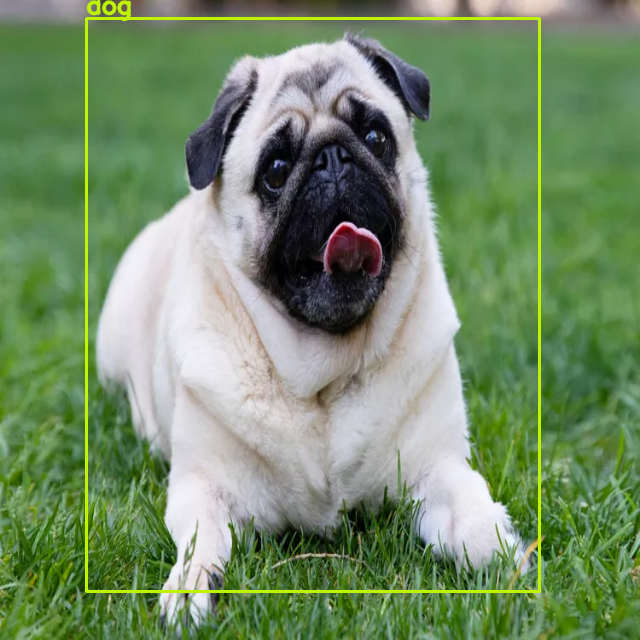

In [11]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color,
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img


image_url = "https://www.thesprucepets.com/thmb/3ABKoAPm0Hu4PcWsDH1giawq7ck=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/chinese-dog-breeds-4797219-hero-2a1e9c5ed2c54d00aef75b05c5db399c.jpg"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

# **To do Next**

・外部のデータセット（Treated）を洗い出し

・内部のデータセットをさらに水増し

・内部および外部データセットより、test用各100枚（grav50枚、cont50枚）を抜き出しておき、合体する

・既存のYOLOv5を用いてbounding boxを抜き出し、新たにトレーニングする